## The usual imports

In [1]:
# the usual imports
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import cv2

## Loading data
Bounding boxes are encoded in the format expected by darknet:

 - label
 - center x in [0,1]
 - center y in [0,1]
 - width in  [0,1]
 - height in [0,1]
 
All coordinates are normalized.

We create a sample annotation and plot the corresponding rectangle.
Then we distort the image, including the rectangle.

After the distortions (=augmentations) we need to create a bounding box which contains the distorted original rectangle.

In [2]:
# some helper functions
# they can write rectangles on numpy arrays
from utils.plot_utils import draw_rect, create_canvas, draw_point

In [3]:
canvas = create_canvas(colored=True)

label = 1
rect = [0.5, 0.5, 0.8, 0.4]
annotation = [label, *rect]

canvas = draw_rect(canvas, rect, color=(1, 0, 0), thickness=1)

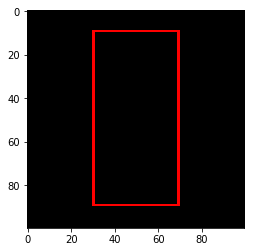

In [4]:
plt.imshow(canvas)
plt.show()

## Extracting and drawing vertices
The rectangle has 4 vertices. Every vertex is encoded as (x,y) also in normalized coordinates.

To extract the vertices, we convert the rectangle in the annotation to a new format, all coordinates are in [0,1] again
 - x_min
 - y_min
 - x_max
 - y_max
 
Then we strip off the annotation labels.

Finally we convert the rectangle to vertices and draw them.

In [5]:
# converting between different formats of bounding boxes
from utils.object import minmax_to_wh, wh_to_minmax

# splitting labels from bounding boxes and adding the labels back again
from utils.object import split, merge

# converting boxes to vertices and vertices to boxes
from utils.bbox import boxes_to_vertices, vertices_to_boxes

In [6]:
# the annotations are stored in the format: x, y, width, height
# for the augmentation we need : x_min, y_min, x_max, y_max
# conversion is done by this function

# the function expects a list of rectangles, we have to wrap the annotations in []
annotations = [annotation]
annotations_minmax = wh_to_minmax(annotations)

In [7]:
# the split functions separates the annotations into labels and rectangles
labels, rects = split(annotations_minmax)

# now we convert every rectangle into 4 vertices
rects = np.array(rects)
vertices = boxes_to_vertices(rects)

In [8]:
# the resulting vertices array has 3 dimensions
# first axis: enumerates the rectangles
# second axis: enumerates the vertices of a rectangle, always 4
# third axis: x and y

# we have just one rectangle in this demo, so the first dimension is 1
vertices.shape

(1, 4, 2)

In [9]:
# for the rest of the code, we actually need to have a 2D array
# we apply the transformations along the first axis in parallel
# because of this technical detail, the vertices need to be stacked along this axis
vertices = vertices.reshape([-1, 2])

In [10]:
c1 = canvas.copy()

for point in vertices:
    draw_point(c1, point, color=(0, 1, 0), thickness = 2)

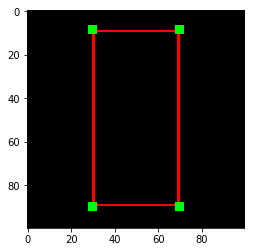

In [11]:
plt.imshow(c1)
plt.show()

## Augmenting the image and the vertices
For the augmentation, I've taken the code from Keras' random_transform and added support to apply the same transformation matrices to vertices

In [12]:
from augmentations import random_transform_with_vertices

Using TensorFlow backend.


In [13]:
# the transformations have the center of the image as pivot point
# shift the vertices so that their origin becomes the center of the image
vertices -= [0.5, 0.5]

# apply image transformations
canvas_augmented, vertices_augmented = random_transform_with_vertices(canvas, vertices,
                                               rg= 30, 
                                               wrg=0.1, hrg=0.1, 
                                               zoom_range=(0.9, 1.1), 
                                               row_axis=0, col_axis=1, channel_axis=2)

# undo the origin shifting
vertices_augmented += [0.5, 0.5]

# clip to allowed range
vertices_augmented = np.clip(vertices_augmented, 0, 1)

In [14]:
c2 = canvas_augmented.copy()

for point in vertices_augmented:
    draw_point(c2, point, color=(0, 1, 0), thickness = 2)

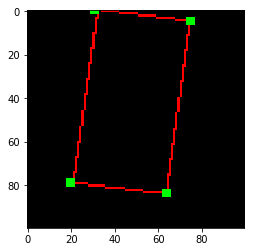

In [15]:
plt.imshow(c2)
plt.show()

## Convert back to a bounding box
We have the vertices transformed along with the original image.
But we need to put a bounding box around this.

In [16]:
# convert back to boxes
boxes_augmented = vertices_to_boxes(vertices_augmented)

# zip this back together with the original labels
objects = merge(labels, boxes_augmented)

# conver to the original width-height format
objects = minmax_to_wh(objects)

In [17]:
c3 = c2.copy()

for obj in objects:
    rect = obj[1:]
    c3 = draw_rect(c3, rect, color=(0, 1, 1), thickness=1)

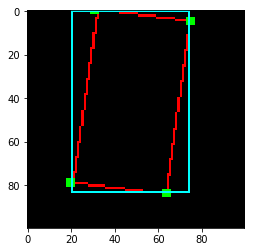

In [18]:
plt.imshow(c3)
plt.show()